# Experimento 1: Transfer Learning con Autoencoders U-Net

Este notebook implementa el Experimento 1 del proyecto, usando módulos de Python separados para la carga de datos.

## Configuración con Hydra
- Gestión de configuraciones jerárquicas usando archivos YAML
- Configuraciones organizadas por modelo, datos, entrenamiento y experimento
- Hiperparámetros centralizados para fácil modificación
- Control de reproducibilidad con semillas configurables

## Optimizaciones GPU
- Configuración automática de acelerador y dispositivos
- Precisión mixta habilitada para GPU
- Batch size adaptativo según memoria disponible
- Optimizaciones cuDNN habilitadas
- Manejo correcto de dispositivos


In [1]:
# Imports básicos
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchmetrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import wandb
import os
import warnings
warnings.filterwarnings('ignore')

# Importar nuestros módulos de carga de datos
from dataset import ButterflyDataset, get_transforms
from datamodule import ButterflyDataModule

# Importar configuración de Hydra
from hydra_config import (
    setup_experiment_1_config, 
    print_config_summary,
    get_data_module_config,
    get_model_config,
    get_trainer_config
)

print("Cargando configuración con Hydra...")
print("=" * 50)

# Cargar configuración del Experimento 1 usando Hydra
cfg, device_config, wandb_config = setup_experiment_1_config(data_split="70_30")

# Mostrar resumen de configuración
print_config_summary(cfg, device_config)

# Extraer configuraciones específicas
device = device_config['device']
BATCH_SIZE = device_config['batch_size']
IMAGE_SIZE = cfg.data.image_size
NUM_EPOCHS = cfg.training.max_epochs
LEARNING_RATE = cfg.training.learning_rate
SEED = cfg.seed

print(f"\nConfiguración aplicada:")
print(f"Device: {device}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Image Size: {IMAGE_SIZE}")
print(f"Epochs: {NUM_EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Seed: {SEED}")

# Limpiar caché de GPU si está disponible
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print(f'\nPyTorch version: {torch.__version__}')
print(f'PyTorch Lightning version: {pl.__version__}')


Using device: cuda
GPU disponible: NVIDIA GeForce RTX 3070
Memoria GPU total: 8.0 GB
Versión CUDA: 12.1
cuDNN habilitado: True
Precisión mixta disponible: True
PyTorch version: 2.5.1+cu121
PyTorch Lightning version: 2.5.1.post0


In [2]:
# Configuración desde Hydra
print("Aplicando configuración desde Hydra...")

# Extraer configuración de datos desde Hydra
data_module_config = get_data_module_config(cfg, device_config)
DATA_DIR = data_module_config['data_dir']
METADATA_CSV = data_module_config['metadata_csv']

print(f"Directorio de datos: {DATA_DIR}")
print(f"Archivo de metadata: {METADATA_CSV}")

# Las optimizaciones de GPU se configuraron automáticamente
print(f"Optimizaciones GPU: {'Habilitadas' if torch.cuda.is_available() else 'No disponibles'}")

# Configurar Wandb
print("Inicializando Wandb...")
wandb.init(**wandb_config)


Seed set to 42


Batch size ajustado para GPU: 32
Optimizaciones de cuDNN habilitadas


wandb: Currently logged in as: jpablix (bitfalt-itcr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
# Configurar DataModule usando configuración de Hydra
print("Configurando DataModule con Hydra...")

data_module_70_30 = ButterflyDataModule(**data_module_config)

# Configurar datasets
data_module_70_30.setup()
print("\nInformación del dataset 70-30:")
info = data_module_70_30.get_dataset_info()
for key, value in info.items():
    print(f"  {key}: {value}")
    
print(f"\nDataModule configurado exitosamente")
print(f"   - Split: {cfg.data.splits.labeled_ratio*100:.0f}% etiquetado, {(1-cfg.data.splits.labeled_ratio)*100:.0f}% no etiquetado")
print(f"   - Batch size: {data_module_config['batch_size']}")
print(f"   - Workers: {data_module_config['num_workers']}")
print(f"   - Image size: {data_module_config['image_size']}")


Found 3693 images across 30 classes
Classes: ['ARCIGERA FLOWER MOTH', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED TIGER MOTH', 'BIRD CHERRY ERMINE MOTH', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CLEOPATRA', 'COPPER TAIL', 'CRECENT', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN PINE ELFIN', 'EMPEROR GUM MOTH', 'GREAT JAY', 'GREEN HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'Iphiclus sister', 'MILBERTS TORTOISESHELL', 'MOURNING CLOAK', 'ORANGE TIP', 'RED CRACKER', 'ROSY MAPLE MOTH', 'SCARCE SWALLOW', 'SLEEPY ORANGE', 'WHITE LINED SPHINX MOTH']
Dataset splits - Train: 2584, Val: 739, Test: 370
Semi-supervised split - Labeled: 775, Unlabeled: 1809
Información del dataset 70-30:
num_classes: 30
class_names: ['ARCIGERA FLOWER MOTH', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED TIGER MOTH', 'BIRD CHERRY ERMINE MOTH', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CLEOPATRA', 'COPPER

In [4]:
# Verificación de configuración de GPU y PyTorch Lightning
print("=== VERIFICACIÓN DE CONFIGURACIÓN ===")
print(f"✓ PyTorch detecta CUDA: {torch.cuda.is_available()}")
print(f"✓ Número de GPUs disponibles: {torch.cuda.device_count()}")

# Crear un tensor pequeño para verificar que GPU funciona
if torch.cuda.is_available():
    try:
        test_tensor = torch.randn(10, 10).cuda()
        result = test_tensor @ test_tensor.T
        print(f"✓ Operaciones en GPU funcionando correctamente")
        print(f"✓ Dispositivo de prueba: {test_tensor.device}")
        del test_tensor, result
        torch.cuda.empty_cache()
    except Exception as e:
        print(f"❌ Error en operaciones GPU: {e}")
        print("Recomendación: Verificar instalación de CUDA/drivers")

# Verificar que PyTorch Lightning puede detectar GPU
trainer_test = pl.Trainer(accelerator='auto', devices='auto', max_epochs=1)
print(f"✓ PyTorch Lightning accelerator: {trainer_test.accelerator}")
print(f"✓ PyTorch Lightning devices: {trainer_test.num_devices}")

print("\\n=== CONFIGURACIÓN FINAL ===")
print(f"Dispositivo principal: {device}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Precisión mixta: {'Habilitada' if torch.cuda.is_available() else 'No disponible (CPU)'}")
print("=" * 50)


=== VERIFICACIÓN DE CONFIGURACIÓN ===
✓ PyTorch detecta CUDA: True
✓ Número de GPUs disponibles: 1
✓ Operaciones en GPU funcionando correctamente
✓ Dispositivo de prueba: cuda:0


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


✓ PyTorch Lightning accelerator: <pytorch_lightning.accelerators.cuda.CUDAAccelerator object at 0x000002AAB4B3C0D0>
✓ PyTorch Lightning devices: 1
\n=== CONFIGURACIÓN FINAL ===
Dispositivo principal: cuda
Batch size: 32
Precisión mixta: Habilitada


## Definición de Modelos

### 1. U-Net Autoencoder
Implementación de U-Net con skip connections obligatorias para el preentrenamiento no supervisado.


In [5]:
class DoubleConv(nn.Module):
    """Doble convolución: (conv => BN => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling con maxpool y double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling con transpose conv y double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Skip connection - OBLIGATORIA según especificaciones
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)  # Skip connection
        return self.conv(x)


In [6]:
class UNetAutoencoder(pl.LightningModule):
    """
    U-Net Autoencoder con skip connections obligatorias.
    Usado para preentrenamiento no supervisado.
    """
    def __init__(self, n_channels=3, learning_rate=1e-3):
        super().__init__()
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        
        # Encoder (Contracting path)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # Decoder (Expansive path)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_channels, kernel_size=1)
        
        # Para extraer features del encoder
        self.encoder_features = None
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Guardar features del encoder para transfer learning
        self.encoder_features = x5
        
        # Decoder con skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return torch.sigmoid(logits)  # Salida entre 0 y 1
    
    def get_encoder_features(self, x):
        """Extrae features del encoder para transfer learning"""
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        return x5
    
    def training_step(self, batch, batch_idx):
        if isinstance(batch, (list, tuple)):
            x = batch[0]  # Get only images, ignore labels
        else:
            x = batch

        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        
        self.log('train_loss', loss, prog_bar=True)
        wandb.log({'train_autoencoder_loss': loss})
        return loss
    
    def validation_step(self, batch, batch_idx):
        if isinstance(batch, (list, tuple)):
            x = batch[0]  # Get only images, ignore labels
        else:
            x = batch

        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        
        self.log('val_loss', loss, prog_bar=True)
        wandb.log({'val_autoencoder_loss': loss})
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }


### 2. Clasificadores

Implementación de los tres clasificadores requeridos:
- **Clasificador A**: Sin preentrenamiento
- **Clasificador B1**: Con preentrenamiento, encoder congelado
- **Clasificador B2**: Con preentrenamiento, fine-tuning completo


In [7]:
class ButterflyClassifier(pl.LightningModule):
    """
    Clasificador base para mariposas.
    Puede usar features preentrenadas del autoencoder o entrenar desde cero.
    """
    def __init__(self, num_classes, learning_rate=1e-3, pretrained_encoder=None, freeze_encoder=False):
        super().__init__()
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.freeze_encoder = freeze_encoder
        self.save_hyperparameters(ignore=['pretrained_encoder'])
        
        if pretrained_encoder is not None:
            # Usar encoder preentrenado
            self.encoder = nn.Sequential(
                pretrained_encoder.inc,
                pretrained_encoder.down1,
                pretrained_encoder.down2,
                pretrained_encoder.down3,
                pretrained_encoder.down4
            )
            
            if freeze_encoder:
                # Congelar parámetros del encoder (B1)
                for param in self.encoder.parameters():
                    param.requires_grad = False
                print("Encoder congelado para fine-tuning")
            else:
                print("Encoder descongelado para fine-tuning completo")
        else:
            # Crear encoder desde cero (Clasificador A)
            self.encoder = nn.Sequential(
                DoubleConv(3, 64),
                Down(64, 128),
                Down(128, 256),
                Down(256, 512),
                Down(512, 1024)
            )
            print("Encoder creado desde cero")
        
        # Clasificador
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )
        
        # Métricas
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)
    
    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        acc = self.train_acc(preds, y)
        
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        acc = self.val_acc(preds, y)
        
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        preds = torch.argmax(logits, dim=1)
        acc = self.test_acc(preds, y)
        
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        
        return {'test_loss': loss, 'test_acc': acc, 'preds': preds, 'targets': y}
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }


## Funciones de Entrenamiento y Evaluación


In [8]:
def train_autoencoder(data_module, max_epochs=30):
    """Entrena el autoencoder U-Net"""
    print("=== Entrenando Autoencoder U-Net ===")
    
    # Crear modelo
    autoencoder = UNetAutoencoder(learning_rate=LEARNING_RATE)
    
    # Callbacks
    callbacks = [
        pl.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            mode='min'
        ),
        pl.callbacks.ModelCheckpoint(
            monitor='val_loss',
            mode='min',
            save_top_k=1,
            filename='autoencoder-{epoch:02d}-{val_loss:.2f}'
        )
    ]
    
    # Trainer - Configuración automática de GPU
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=callbacks,
        accelerator='auto',  # Cambiado de 'cpu' a 'auto'
        devices='auto',      # Cambiado de '1' a 'auto'
        log_every_n_steps=10,
        precision='16-mixed' if torch.cuda.is_available() else '32'  # Usar precisión mixta en GPU
    )
    
    # Entrenar usando datos no etiquetados
    trainer.fit(
        model=autoencoder,
        train_dataloaders=data_module.unlabeled_dataloader(),
        val_dataloaders=data_module.val_dataloader()
    )
    
    return autoencoder


def train_classifier(data_module, pretrained_encoder=None, freeze_encoder=False, 
                    classifier_name="", max_epochs=50):
    """Entrena un clasificador"""
    print(f"=== Entrenando {classifier_name} ===")
    
    # Crear modelo
    classifier = ButterflyClassifier(
        num_classes=data_module.num_classes,
        learning_rate=LEARNING_RATE,
        pretrained_encoder=pretrained_encoder,
        freeze_encoder=freeze_encoder
    )
    
    # Callbacks
    callbacks = [
        pl.callbacks.EarlyStopping(
            monitor='val_acc',
            patience=15,
            mode='max'
        ),
        pl.callbacks.ModelCheckpoint(
            monitor='val_acc',
            mode='max',
            save_top_k=1,
            filename=f'{classifier_name.lower().replace(" ", "_")}-{{epoch:02d}}-{{val_acc:.2f}}'
        )
    ]
    
    # Trainer - Configuración automática de GPU
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=callbacks,
        accelerator='auto',  # Cambiado de 'cpu' a 'auto'
        devices='auto',      # Cambiado de '1' a 'auto'
        log_every_n_steps=10,
        precision='16-mixed' if torch.cuda.is_available() else '32'  # Usar precisión mixta en GPU
    )
    
    # Entrenar usando datos etiquetados
    trainer.fit(
        model=classifier,
        train_dataloaders=data_module.labeled_dataloader(),
        val_dataloaders=data_module.val_dataloader()
    )
    
    return classifier, trainer


def evaluate_model(model, data_module, model_name=""):
    """Evalúa un modelo y retorna métricas detalladas"""
    print(f"=== Evaluando {model_name} ===")
    
    # Crear trainer para testing - Configuración automática de GPU
    trainer = pl.Trainer(
        accelerator='auto',  # Cambiado de 'cpu' a 'auto'
        devices='auto',      # Cambiado de '1' a 'auto'
        precision='16-mixed' if torch.cuda.is_available() else '32'
    )
    
    # Evaluar en conjunto de test
    test_results = trainer.test(model, data_module.test_dataloader())[0]
    
    # Obtener predicciones para matriz de confusión
    model.eval()
    all_preds = []
    all_targets = []
    
    # Determinar dispositivo del modelo
    device = next(model.parameters()).device
    
    with torch.no_grad():
        for batch in data_module.test_dataloader():
            x, y = batch
            x, y = x.to(device), y.to(device)  # Usar device del modelo
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())
    
    # Calcular métricas adicionales
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='weighted'
    )
    
    results = {
        'model_name': model_name,
        'test_accuracy': test_results['test_acc'],
        'test_loss': test_results['test_loss'],
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': all_preds,
        'targets': all_targets
    }
    
    # Log a Wandb
    wandb.log({
        f'{model_name}_test_accuracy': test_results['test_acc'],
        f'{model_name}_test_loss': test_results['test_loss'],
        f'{model_name}_precision': precision,
        f'{model_name}_recall': recall,
        f'{model_name}_f1_score': f1
    })
    
    return results


## Experimento 70/30 (70% no etiquetado, 30% etiquetado)

Primer experimento con división 70-30 de los datos.


In [9]:
# Entrenar autoencoder con datos no etiquetados (70%)
autoencoder_70_30 = train_autoencoder(data_module_70_30, max_epochs=30)

print("\\nAutoencoder 70-30 entrenado exitosamente!")


=== Entrenando Autoencoder U-Net ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | inc   | DoubleConv | 39.0 K | train
1 | down1 | Down       | 221 K  | train
2 | down2 | Down       | 886 K  | train
3 | down3 | Down       | 3.5 M  | train
4 | down4 | Down       | 14.2 M | train
5 | up1   | Up         | 9.2 M  | train
6 | up2   | Up         | 2.3 M  | train
7 | up3   | Up         | 574 K  | train
8 | up4   | Up         | 14

Epoch 0: 100%|██████████| 57/57 [00:51<00:00,  1.12it/s, v_num=12, train_loss=1.240]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 57/57 [00:26<00:00,  2.18it/s, v_num=12, train_loss=1.280, val_loss=0.952]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 57/57 [00:26<00:00,  2.16it/s, v_num=12, train_loss=1.390, val_loss=0.882]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 57/57 [00:25<00:00,  2.26it/s, v_num=12, train_loss=1.450, val_loss=0.859]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 57/57 [00:25<00:00,  2.23it/s, v_num=12, train_loss=1.340, val_loss=0.851]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 57/57 [00:25<00:00,  2.23it/s, v_num=12, train_loss=1.080, val_loss=0.847]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 57/57 [00:25<00:00,  2.20it/s, v_num=12, train_loss=1.200, val_loss=0.843]
Validation: |          | 0/? [00:

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 57/57 [00:29<00:00,  1.94it/s, v_num=12, train_loss=1.310, val_loss=0.837]
\nAutoencoder 70-30 entrenado exitosamente!


In [10]:
# Entrenar los tres clasificadores para experimento 70-30

# Clasificador A: Sin preentrenamiento
print("\\n" + "="*50)
classifier_A_70_30, trainer_A = train_classifier(
    data_module_70_30, 
    pretrained_encoder=None, 
    freeze_encoder=False,
    classifier_name="Clasificador A (Sin preentrenamiento) 70-30",
    max_epochs=NUM_EPOCHS
)

# Clasificador B1: Con preentrenamiento, encoder congelado
print("\\n" + "="*50)
classifier_B1_70_30, trainer_B1 = train_classifier(
    data_module_70_30, 
    pretrained_encoder=autoencoder_70_30, 
    freeze_encoder=True,
    classifier_name="Clasificador B1 (Preentrenado congelado) 70-30",
    max_epochs=NUM_EPOCHS
)

# Clasificador B2: Con preentrenamiento, fine-tuning completo
print("\\n" + "="*50)
classifier_B2_70_30, trainer_B2 = train_classifier(
    data_module_70_30, 
    pretrained_encoder=autoencoder_70_30, 
    freeze_encoder=False,
    classifier_name="Clasificador B2 (Preentrenado fine-tuning) 70-30",
    max_epochs=NUM_EPOCHS
)

print("\\nTodos los clasificadores 70-30 entrenados exitosamente!")


\n==================================================
=== Entrenando Clasificador A (Sin preentrenamiento) 70-30 ===
Encoder creado desde cero


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | Sequential         | 18.9 M | train
1 | classifier | Sequential         | 540 K  | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | val_acc    | MulticlassAccuracy | 0      | train
4 | test_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
19.4 M    Trainable params
0         Non-trainable params
19.4 M    Total params
77.565    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 25/25 [00:07<00:00,  3.39it/s, v_num=13, train_loss=3.600, train_acc=0.143] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 25/25 [00:04<00:00,  5.78it/s, v_num=13, train_loss=2.640, train_acc=0.429, val_loss=7.530, val_acc=0.0514] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 25/25 [00:04<00:00,  5.67it/s, v_num=13, train_loss=2.900, train_acc=0.143, val_loss=3.170, val_acc=0.107] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 25/25 [00:04<00:00,  5.78it/s, v_num=13, train_loss=2.990, train_acc=0.286, val_loss=3.090, val_acc=0.133] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 25/25 [00:04<00:00,  5.96it/s, v_num=13, train_loss=3.140, train_acc=0.286, val_loss=3.720, val_acc=0.103] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 25/25 [00:04<00:00,  5.76it/s, v_num=13, train_loss=2.780, train_acc=0.286, val_loss=2.900, val_acc=0.17

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:06<00:00,  4.14it/s, v_num=13, train_loss=1.120, train_acc=0.571, val_loss=1.600, val_acc=0.556]
\n==================================================
=== Entrenando Clasificador B1 (Preentrenado congelado) 70-30 ===
Encoder congelado para fine-tuning


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | Sequential         | 18.9 M | train
1 | classifier | Sequential         | 540 K  | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | val_acc    | MulticlassAccuracy | 0      | train
4 | test_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
540 K     Trainable params
18.9 M    Non-trainable params
19.4 M    Total params
77.565    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 25/25 [00:02<00:00, 11.67it/s, v_num=14, train_loss=3.670, train_acc=0.000] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 25/25 [00:02<00:00, 12.30it/s, v_num=14, train_loss=3.680, train_acc=0.000, val_loss=3.500, val_acc=0.046] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 25/25 [00:02<00:00, 12.32it/s, v_num=14, train_loss=3.120, train_acc=0.000, val_loss=3.350, val_acc=0.046] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 25/25 [00:02<00:00, 12.31it/s, v_num=14, train_loss=3.460, train_acc=0.000, val_loss=3.270, val_acc=0.0907] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 25/25 [00:02<00:00, 12.05it/s, v_num=14, train_loss=3.360, train_acc=0.143, val_loss=3.240, val_acc=0.0907] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 25/25 [00:01<00:00, 12.86it/s, v_num=14, train_loss=3.180, train_acc=0.143, val_loss=3.250, val_acc=0.0

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:03<00:00,  6.67it/s, v_num=14, train_loss=3.580, train_acc=0.000, val_loss=3.190, val_acc=0.122]
\n==================================================
=== Entrenando Clasificador B2 (Preentrenado fine-tuning) 70-30 ===
Encoder descongelado para fine-tuning completo


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | Sequential         | 18.9 M | train
1 | classifier | Sequential         | 540 K  | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | val_acc    | MulticlassAccuracy | 0      | train
4 | test_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
540 K     Trainable params
18.9 M    Non-trainable params
19.4 M    Total params
77.565    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 25/25 [00:02<00:00, 12.26it/s, v_num=15, train_loss=3.660, train_acc=0.000] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 25/25 [00:02<00:00, 12.36it/s, v_num=15, train_loss=3.600, train_acc=0.000, val_loss=3.390, val_acc=0.0568] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 25/25 [00:02<00:00, 11.66it/s, v_num=15, train_loss=3.340, train_acc=0.286, val_loss=3.320, val_acc=0.065] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 25/25 [00:02<00:00, 12.36it/s, v_num=15, train_loss=3.350, train_acc=0.143, val_loss=3.310, val_acc=0.0907] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 25/25 [00:01<00:00, 12.77it/s, v_num=15, train_loss=3.210, train_acc=0.143, val_loss=3.290, val_acc=0.088] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 25/25 [00:02<00:00, 12.46it/s, v_num=15, train_loss=3.370, train_acc=0.143, val_loss=3.260, val_acc=0.0

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 25/25 [00:03<00:00,  6.83it/s, v_num=15, train_loss=3.520, train_acc=0.000, val_loss=3.200, val_acc=0.123]
\nTodos los clasificadores 70-30 entrenados exitosamente!


In [11]:
# Evaluar todos los modelos del experimento 70-30
results_70_30 = {}

results_70_30['A'] = evaluate_model(
    classifier_A_70_30, data_module_70_30, 
    "Clasificador A 70-30"
)

results_70_30['B1'] = evaluate_model(
    classifier_B1_70_30, data_module_70_30, 
    "Clasificador B1 70-30"
)

results_70_30['B2'] = evaluate_model(
    classifier_B2_70_30, data_module_70_30, 
    "Clasificador B2 70-30"
)

print("\\nResultados Experimento 70-30:")
print("-" * 60)
for name, results in results_70_30.items():
    print(f"{results['model_name']}:")
    print(f"  Accuracy: {results['test_accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  F1-Score: {results['f1_score']:.4f}")
    print()


=== Evaluando Clasificador A 70-30 ===


Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 12/12 [00:01<00:00,  8.53it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5405405163764954
        test_loss           1.7068198919296265
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
=== Evaluando Clasificador B1 70-30 ===


Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 13.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.0972972959280014
        test_loss           3.3053500652313232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
=== Evaluando Clasificador B2 70-30 ===


Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 12.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.10000000149011612
        test_loss           3.3219594955444336
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
\nResultados Experimento 70-30:
------------------------------------------------------------
Clasificador A 70-30:
  Accuracy: 0.5405
  Precision: 0.5445
  Recall: 0.5378
  F1-Score: 0.5178

Clasificador B1 70-30:
  Accuracy: 0.0973
  Precision: 0.0508
  Recall: 0.0973
  F1-Score: 0.0516

Clasificador B2 70-30:
  Accuracy: 0.1000
  Precision: 0.0721
  Recall: 0.1000
  F1-Score: 0.0565



## Experimento 90/10 (90% no etiquetado, 10% etiquetado)

Segundo experimento con división 90-10 de los datos para evaluar el impacto de tener menos datos etiquetados.


In [12]:
# Configurar DataModule para experimento 90-10
data_module_90_10 = ButterflyDataModule(
    data_dir=DATA_DIR,
    metadata_csv=METADATA_CSV,
    batch_size=BATCH_SIZE,
    num_workers=4,
    image_size=IMAGE_SIZE,
    labeled_ratio=0.1,  # 10% etiquetado, 90% no etiquetado
    seed=SEED
)

# Configurar datasets
data_module_90_10.setup()
print("Información del dataset 90-10:")
info = data_module_90_10.get_dataset_info()
for key, value in info.items():
    print(f"{key}: {value}")


Found 3693 images across 30 classes
Classes: ['ARCIGERA FLOWER MOTH', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED TIGER MOTH', 'BIRD CHERRY ERMINE MOTH', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CLEOPATRA', 'COPPER TAIL', 'CRECENT', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN PINE ELFIN', 'EMPEROR GUM MOTH', 'GREAT JAY', 'GREEN HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'Iphiclus sister', 'MILBERTS TORTOISESHELL', 'MOURNING CLOAK', 'ORANGE TIP', 'RED CRACKER', 'ROSY MAPLE MOTH', 'SCARCE SWALLOW', 'SLEEPY ORANGE', 'WHITE LINED SPHINX MOTH']
Dataset splits - Train: 2584, Val: 739, Test: 370
Semi-supervised split - Labeled: 258, Unlabeled: 2326
Información del dataset 90-10:
num_classes: 30
class_names: ['ARCIGERA FLOWER MOTH', 'ATALA', 'BANDED ORANGE HELICONIAN', 'BANDED TIGER MOTH', 'BIRD CHERRY ERMINE MOTH', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CLEOPATRA', 'COPPER

In [13]:
# Entrenar autoencoder con datos no etiquetados (90%)
autoencoder_90_10 = train_autoencoder(data_module_90_10, max_epochs=30)

print("\\nAutoencoder 90-10 entrenado exitosamente!")


=== Entrenando Autoencoder U-Net ===


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | inc   | DoubleConv | 39.0 K | train
1 | down1 | Down       | 221 K  | train
2 | down2 | Down       | 886 K  | train
3 | down3 | Down       | 3.5 M  | train
4 | down4 | Down       | 14.2 M | train
5 | up1   | Up         | 9.2 M  | train
6 | up2   | Up         | 2.3 M  | train
7 | up3   | Up         | 574 K  | train
8 | up4   | Up         | 143 K  | train
9 | outc  | Conv2d     | 195    | train
---------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.175   Total estimated model params size (MB)
93        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 73/73 [00:36<00:00,  1.99it/s, v_num=19, train_loss=1.450]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 73/73 [00:30<00:00,  2.39it/s, v_num=19, train_loss=1.340, val_loss=0.966]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 73/73 [02:21<00:00,  0.52it/s, v_num=19, train_loss=1.410, val_loss=0.872]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 73/73 [00:30<00:00,  2.42it/s, v_num=19, train_loss=1.240, val_loss=0.854]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 73/73 [00:30<00:00,  2.37it/s, v_num=19, train_loss=1.340, val_loss=0.847]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s, v_num=19, train_loss=1.410, val_loss=0.844]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 73/73 [00:31<00:00,  2.35it/s, v_num=19, train_loss=1.520, val_loss=0.842]
Validation: |          | 0/? [00:

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 73/73 [00:34<00:00,  2.09it/s, v_num=19, train_loss=1.300, val_loss=0.837]
\nAutoencoder 90-10 entrenado exitosamente!


In [14]:
# Entrenar los tres clasificadores para experimento 90-10

# Clasificador A: Sin preentrenamiento
print("\\n" + "="*50)
classifier_A_90_10, trainer_A_90 = train_classifier(
    data_module_90_10, 
    pretrained_encoder=None, 
    freeze_encoder=False,
    classifier_name="Clasificador A (Sin preentrenamiento) 90-10",
    max_epochs=NUM_EPOCHS
)

# Clasificador B1: Con preentrenamiento, encoder congelado
print("\\n" + "="*50)
classifier_B1_90_10, trainer_B1_90 = train_classifier(
    data_module_90_10, 
    pretrained_encoder=autoencoder_90_10, 
    freeze_encoder=True,
    classifier_name="Clasificador B1 (Preentrenado congelado) 90-10",
    max_epochs=NUM_EPOCHS
)

# Clasificador B2: Con preentrenamiento, fine-tuning completo
print("\\n" + "="*50)
classifier_B2_90_10, trainer_B2_90 = train_classifier(
    data_module_90_10, 
    pretrained_encoder=autoencoder_90_10, 
    freeze_encoder=False,
    classifier_name="Clasificador B2 (Preentrenado fine-tuning) 90-10",
    max_epochs=NUM_EPOCHS
)

print("\\nTodos los clasificadores 90-10 entrenados exitosamente!")


\n==================================================
=== Entrenando Clasificador A (Sin preentrenamiento) 90-10 ===
Encoder creado desde cero


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | Sequential         | 18.9 M | train
1 | classifier | Sequential         | 540 K  | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | val_acc    | MulticlassAccuracy | 0      | train
4 | test_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
19.4 M    Trainable params
0         Non-trainable params
19.4 M    Total params
77.565    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s, v_num=20, train_loss=3.690, train_acc=0.000] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:01<00:00,  5.32it/s, v_num=20, train_loss=3.350, train_acc=0.000, val_loss=3.550, val_acc=0.0311] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:01<00:00,  4.90it/s, v_num=20, train_loss=3.030, train_acc=0.000, val_loss=6.110, val_acc=0.0541] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:01<00:00,  5.67it/s, v_num=20, train_loss=3.550, train_acc=0.000, val_loss=10.70, val_acc=0.0352] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:01<00:00,  5.36it/s, v_num=20, train_loss=3.320, train_acc=0.000, val_loss=4.150, val_acc=0.0717] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 9/9 [00:01<00:00,  5.34it/s, v_num=20, train_loss=3.850, train_acc=0.000, val_loss=3.290, val_acc=0.100] 
Valid

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 9/9 [00:03<00:00,  2.83it/s, v_num=20, train_loss=3.280, train_acc=0.500, val_loss=2.640, val_acc=0.242]
\n==================================================
=== Entrenando Clasificador B1 (Preentrenado congelado) 90-10 ===
Encoder congelado para fine-tuning


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | Sequential         | 18.9 M | train
1 | classifier | Sequential         | 540 K  | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | val_acc    | MulticlassAccuracy | 0      | train
4 | test_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
540 K     Trainable params
18.9 M    Non-trainable params
19.4 M    Total params
77.565    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  8.09it/s, v_num=21, train_loss=3.040, train_acc=0.000] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 10.35it/s, v_num=21, train_loss=3.080, train_acc=0.000, val_loss=3.330, val_acc=0.0866] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 10.82it/s, v_num=21, train_loss=3.490, train_acc=0.000, val_loss=3.320, val_acc=0.069] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 10.97it/s, v_num=21, train_loss=3.310, train_acc=0.500, val_loss=3.250, val_acc=0.0853] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:00<00:00,  9.35it/s, v_num=21, train_loss=3.210, train_acc=0.000, val_loss=3.250, val_acc=0.0704] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 9/9 [00:00<00:00,  9.78it/s, v_num=21, train_loss=3.040, train_acc=0.000, val_loss=3.280, val_acc=0.0961] 
Valid

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | encoder    | Sequential         | 18.9 M | train
1 | classifier | Sequential         | 540 K  | train
2 | train_acc  | MulticlassAccuracy | 0      | train
3 | val_acc    | MulticlassAccuracy | 0      | train
4 | test_acc   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
540 K     Trainable params
18.9 M    Non-trainable params
19.4 M    Total params
77.565    Total estimated model params size (MB)
64        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 9/9 [00:01<00:00,  8.80it/s, v_num=22, train_loss=3.550, train_acc=0.000] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 10.02it/s, v_num=22, train_loss=3.510, train_acc=0.000, val_loss=3.310, val_acc=0.0785] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 9/9 [00:00<00:00,  9.85it/s, v_num=22, train_loss=3.100, train_acc=0.500, val_loss=3.280, val_acc=0.0961] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 10.93it/s, v_num=22, train_loss=3.540, train_acc=0.000, val_loss=3.250, val_acc=0.0744] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 10.81it/s, v_num=22, train_loss=4.060, train_acc=0.000, val_loss=3.220, val_acc=0.0866] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 11.28it/s, v_num=22, train_loss=3.630, train_acc=0.000, val_loss=3.240, val_acc=0.0947] 
Vali

In [15]:
# Evaluar todos los modelos del experimento 90-10
results_90_10 = {}

results_90_10['A'] = evaluate_model(
    classifier_A_90_10, data_module_90_10, 
    "Clasificador A 90-10"
)

results_90_10['B1'] = evaluate_model(
    classifier_B1_90_10, data_module_90_10, 
    "Clasificador B1 90-10"
)

results_90_10['B2'] = evaluate_model(
    classifier_B2_90_10, data_module_90_10, 
    "Clasificador B2 90-10"
)

print("\\nResultados Experimento 90-10:")
print("-" * 60)
for name, results in results_90_10.items():
    print(f"{results['model_name']}:")
    print(f"  Accuracy: {results['test_accuracy']:.4f}")
    print(f"  Precision: {results['precision']:.4f}")
    print(f"  Recall: {results['recall']:.4f}")
    print(f"  F1-Score: {results['f1_score']:.4f}")
    print()


=== Evaluando Clasificador A 90-10 ===


Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 13.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.2432432472705841
        test_loss           2.6652450561523438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
=== Evaluando Clasificador B1 90-10 ===


Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 12.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.08918918669223785
        test_loss           3.1993796825408936
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
=== Evaluando Clasificador B2 90-10 ===


Using 16bit Automatic Mixed Precision (AMP)
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 14.58it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.06756756454706192
        test_loss            3.217179536819458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
\nResultados Experimento 90-10:
------------------------------------------------------------
Clasificador A 90-10:
  Accuracy: 0.2432
  Precision: 0.2022
  Recall: 0.2432
  F1-Score: 0.1966

Clasificador B1 90-10:
  Accuracy: 0.0892
  Precision: 0.0233
  Recall: 0.0892
  F1-Score: 0.0317

Clasificador B2 90-10:
  Accuracy: 0.0676
  Precision: 0.0265
  Recall: 0.0676
  F1-Score: 0.0337



## Cuantización de Modelos

Implementación de cuantización para optimizar el rendimiento de los modelos.


In [16]:
import time
import torch.quantization as quantization

def quantize_model(model, data_loader, model_name=""):
    """
    Cuantiza un modelo usando quantization aware training
    """
    print(f"=== Cuantizando {model_name} ===")
    
    # Mover modelo a CPU para cuantización (requerido por PyTorch)
    original_device = next(model.parameters()).device
    model_cpu = model.cpu()
    model_cpu.eval()
    
    # Preparar modelo para cuantización
    model_quantized = torch.quantization.quantize_dynamic(
        model_cpu, 
        {nn.Linear, nn.Conv2d}, 
        dtype=torch.qint8
    )
    
    # Restaurar modelo original a su dispositivo
    model.to(original_device)
    
    return model_quantized

def compare_model_performance(original_model, quantized_model, data_loader, model_name=""):
    """
    Compara el rendimiento entre modelo original y cuantizado
    """
    print(f"\\n=== Comparando rendimiento: {model_name} ===")
    
    # Función para medir tiempo de inferencia
    def measure_inference_time(model, data_loader, num_batches=10):
        model.eval()
        times = []
        
        # Determinar dispositivo del modelo
        device = next(model.parameters()).device
        
        with torch.no_grad():
            for i, batch in enumerate(data_loader):
                if i >= num_batches:
                    break
                    
                x, _ = batch
                x = x.to(device)  # Mover datos al dispositivo correcto
                start_time = time.time()
                _ = model(x)
                end_time = time.time()
                times.append(end_time - start_time)
        
        return np.mean(times), np.std(times)
    
    # Medir rendimiento
    orig_mean, orig_std = measure_inference_time(original_model, data_loader)
    quant_mean, quant_std = measure_inference_time(quantized_model, data_loader)
    
    # Calcular tamaños de modelo
    def get_model_size(model):
        param_size = 0
        buffer_size = 0
        
        for param in model.parameters():
            param_size += param.nelement() * param.element_size()
        
        for buffer in model.buffers():
            buffer_size += buffer.nelement() * buffer.element_size()
        
        return (param_size + buffer_size) / 1024 / 1024  # MB
    
    orig_size = get_model_size(original_model)
    quant_size = get_model_size(quantized_model)
    
    # Resultados
    results = {
        'model_name': model_name,
        'original_inference_time_mean': orig_mean,
        'original_inference_time_std': orig_std,
        'quantized_inference_time_mean': quant_mean,
        'quantized_inference_time_std': quant_std,
        'speedup': orig_mean / quant_mean,
        'original_size_mb': orig_size,
        'quantized_size_mb': quant_size,
        'compression_ratio': orig_size / quant_size
    }
    
    print(f"Modelo Original (dispositivo: {next(original_model.parameters()).device}):")
    print(f"  Tiempo de inferencia: {orig_mean:.4f} ± {orig_std:.4f} segundos")
    print(f"  Tamaño: {orig_size:.2f} MB")
    print(f"\\nModelo Cuantizado (dispositivo: {next(quantized_model.parameters()).device}):")
    print(f"  Tiempo de inferencia: {quant_mean:.4f} ± {quant_std:.4f} segundos")
    print(f"  Tamaño: {quant_size:.2f} MB")
    print(f"\\nMejoras:")
    print(f"  Speedup: {results['speedup']:.2f}x")
    print(f"  Compresión: {results['compression_ratio']:.2f}x")
    
    # Log a Wandb
    wandb.log({
        f'{model_name}_quantization_speedup': results['speedup'],
        f'{model_name}_quantization_compression': results['compression_ratio'],
        f'{model_name}_original_size_mb': orig_size,
        f'{model_name}_quantized_size_mb': quant_size
    })
    
    return results, quantized_model


In [17]:
# Cuantizar los mejores modelos de cada experimento
quantization_results = {}

# Experimento 70-30
print("\\n" + "="*60)
print("CUANTIZACIÓN EXPERIMENTO 70-30")
print("="*60)

# Cuantizar clasificador B2 (mejor rendimiento esperado)
model_B2_70_30_quantized = quantize_model(
    classifier_B2_70_30, 
    data_module_70_30.test_dataloader(), 
    "Clasificador B2 70-30"
)

quantization_results['B2_70_30'], _ = compare_model_performance(
    classifier_B2_70_30, 
    model_B2_70_30_quantized,
    data_module_70_30.test_dataloader(),
    "Clasificador B2 70-30"
)

# Experimento 90-10
print("\\n" + "="*60)
print("CUANTIZACIÓN EXPERIMENTO 90-10")
print("="*60)

# Cuantizar clasificador B2 (mejor rendimiento esperado)
model_B2_90_10_quantized = quantize_model(
    classifier_B2_90_10, 
    data_module_90_10.test_dataloader(), 
    "Clasificador B2 90-10"
)

quantization_results['B2_90_10'], _ = compare_model_performance(
    classifier_B2_90_10, 
    model_B2_90_10_quantized,
    data_module_90_10.test_dataloader(),
    "Clasificador B2 90-10"
)


\n============================================================
CUANTIZACIÓN EXPERIMENTO 70-30
=== Cuantizando Clasificador B2 70-30 ===
\n=== Comparando rendimiento: Clasificador B2 70-30 ===
Modelo Original (dispositivo: cpu):
  Tiempo de inferencia: 10.9539 ± 0.1690 segundos
  Tamaño: 74.00 MB
\nModelo Cuantizado (dispositivo: cpu):
  Tiempo de inferencia: 10.9639 ± 0.1733 segundos
  Tamaño: 71.94 MB
\nMejoras:
  Speedup: 1.00x
  Compresión: 1.03x
\n============================================================
CUANTIZACIÓN EXPERIMENTO 90-10
=== Cuantizando Clasificador B2 90-10 ===
\n=== Comparando rendimiento: Clasificador B2 90-10 ===
Modelo Original (dispositivo: cpu):
  Tiempo de inferencia: 10.9357 ± 0.1343 segundos
  Tamaño: 74.00 MB
\nModelo Cuantizado (dispositivo: cpu):
  Tiempo de inferencia: 10.8545 ± 0.0685 segundos
  Tamaño: 71.94 MB
\nMejoras:
  Speedup: 1.01x
  Compresión: 1.03x


## Visualizaciones y Análisis Comparativo


\n============================================================
GENERANDO VISUALIZACIONES


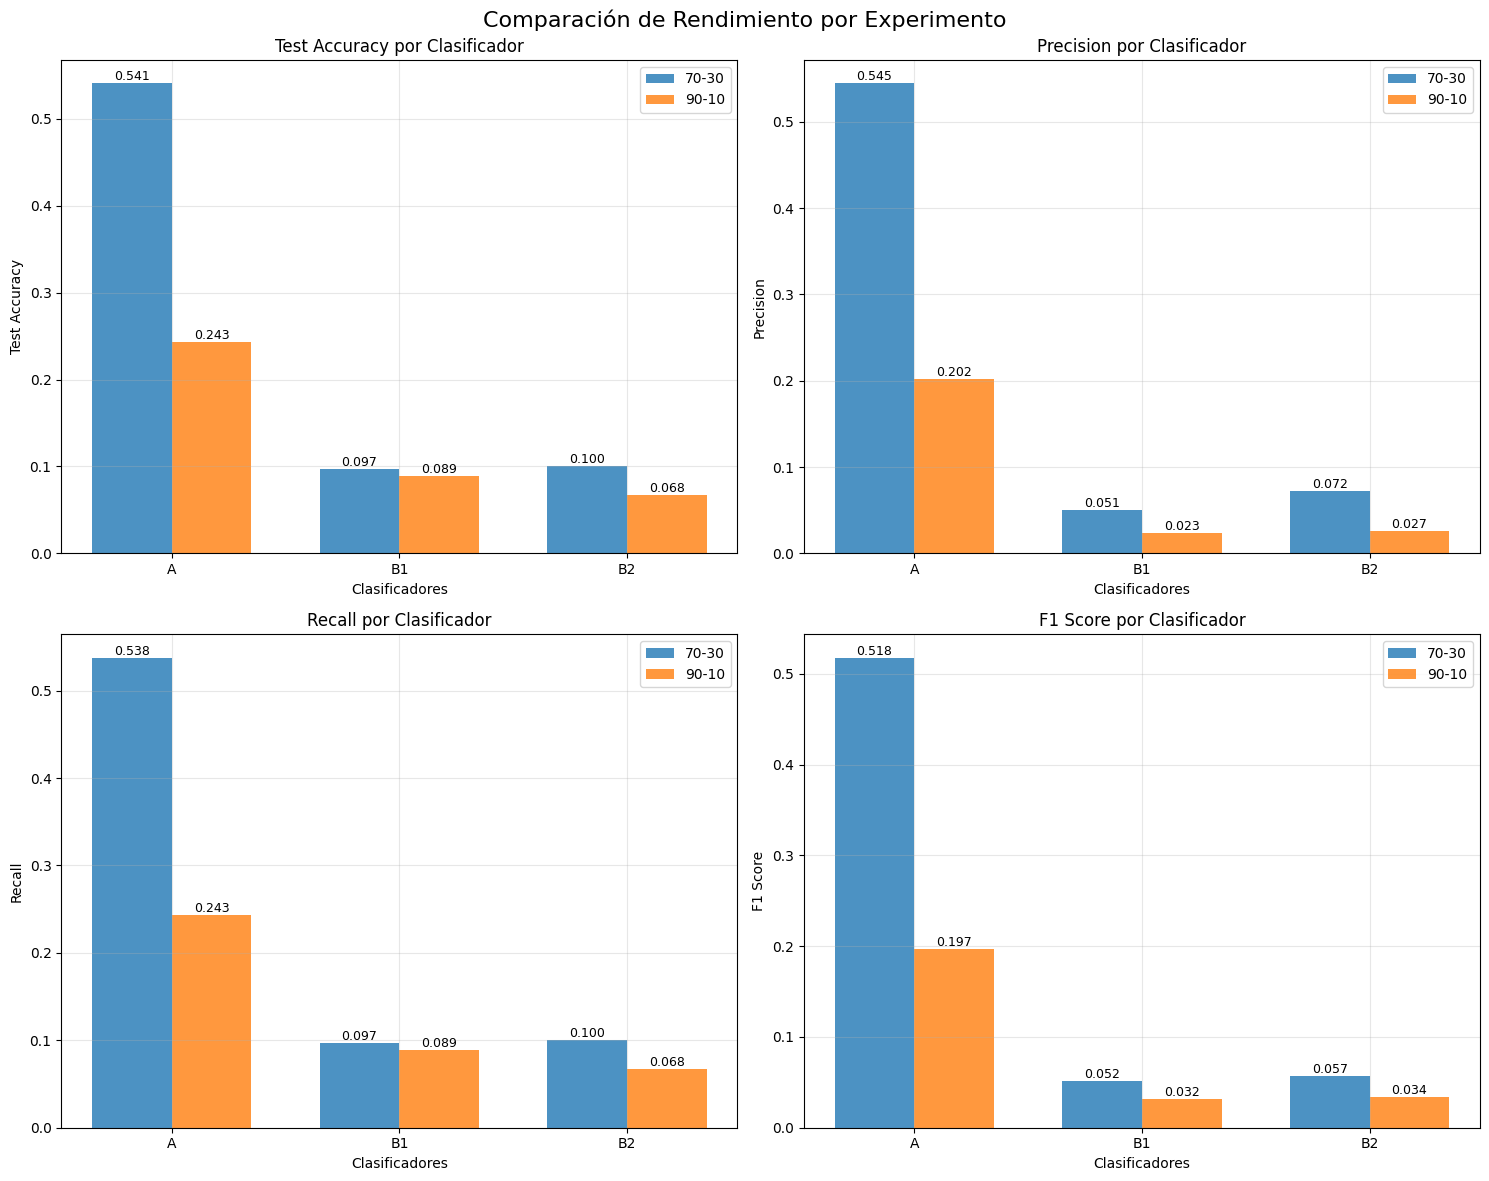

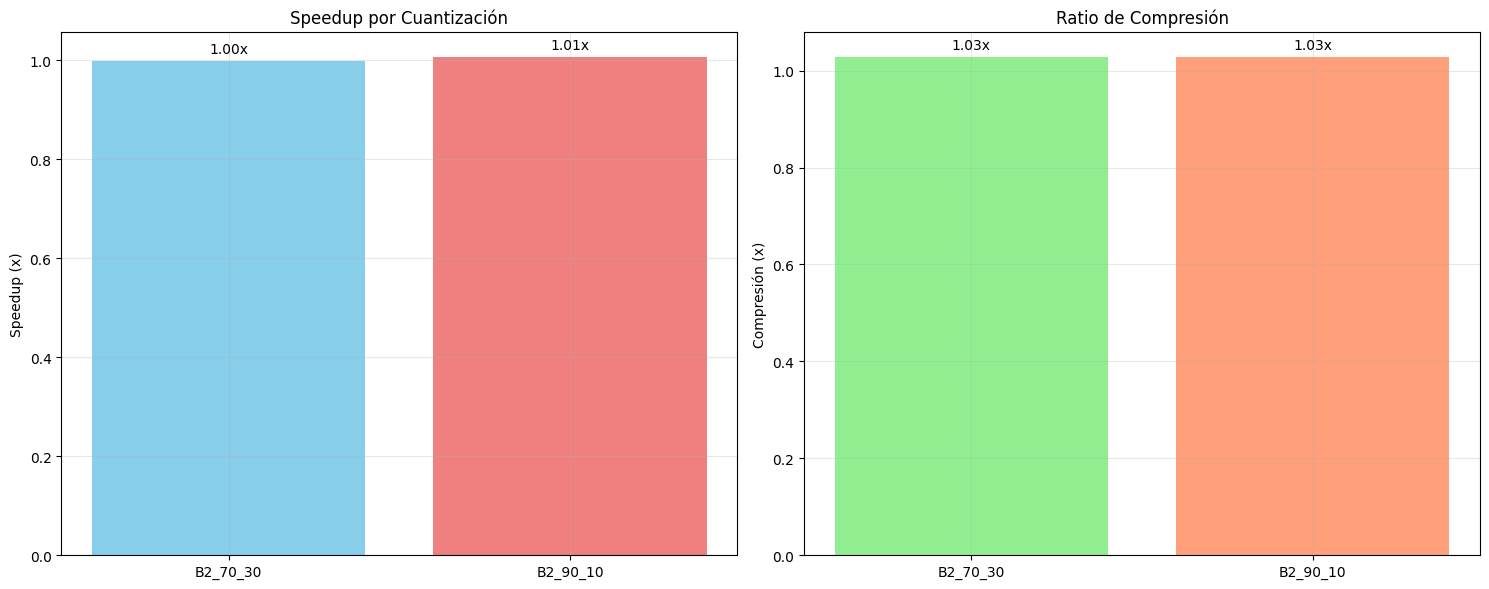

\nMatrices de Confusión:


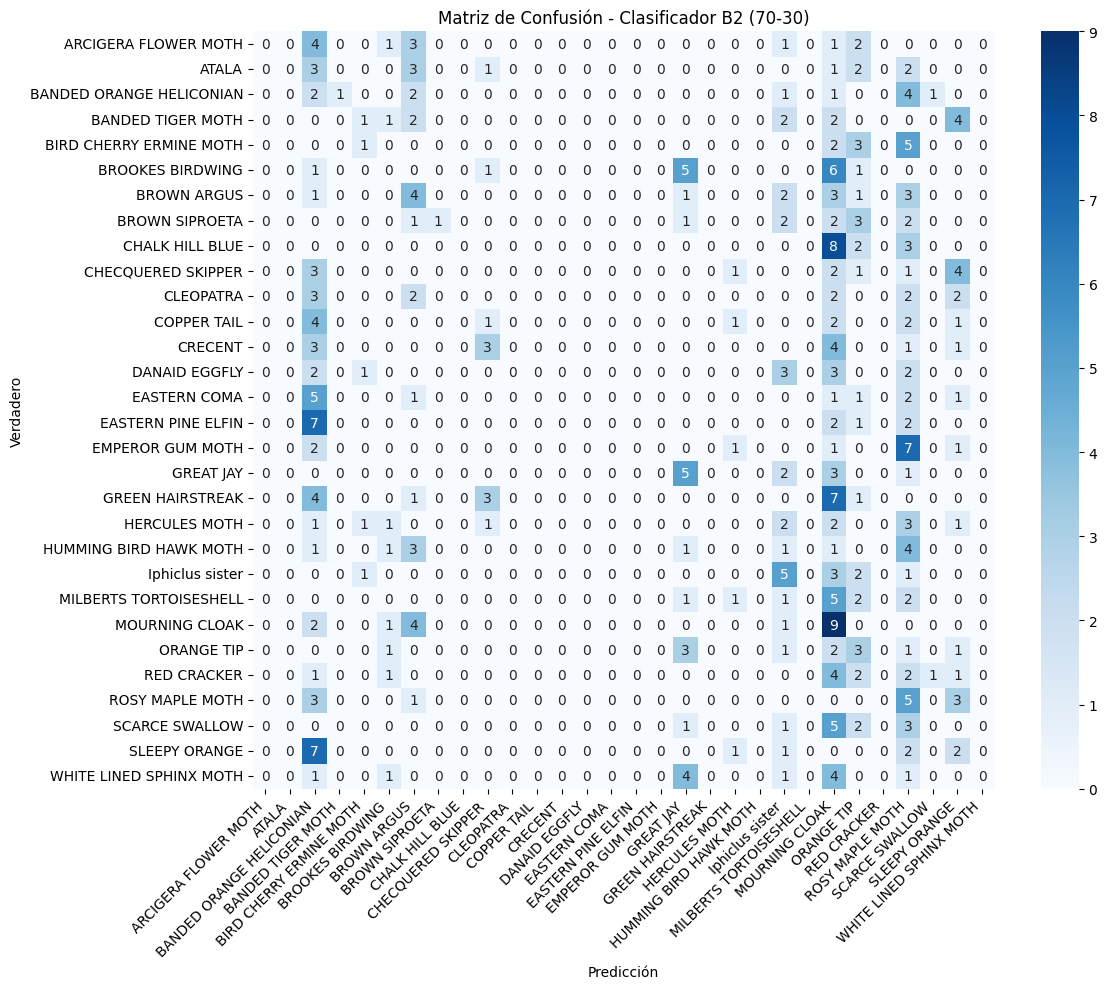

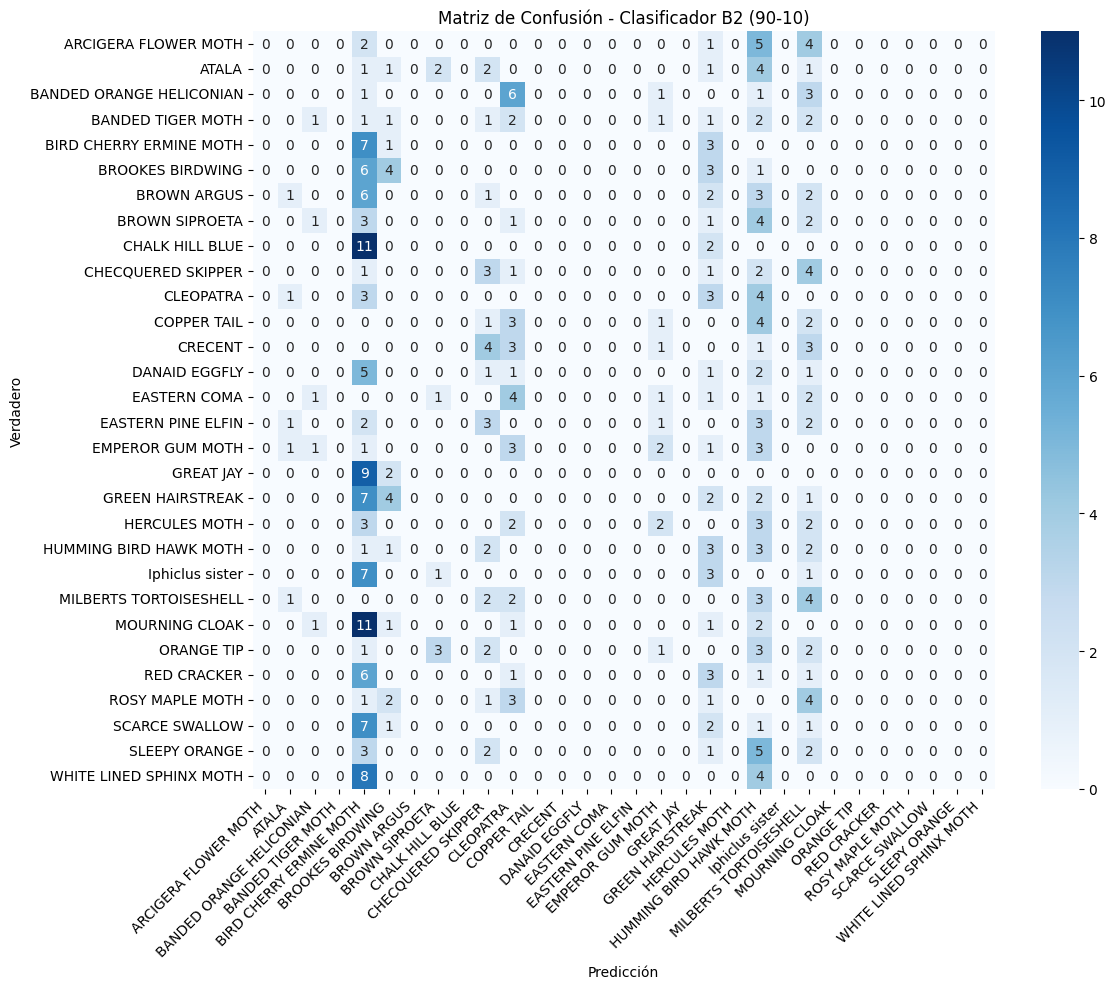

In [18]:
def plot_confusion_matrix(results, class_names, title=""):
    """Plotea matriz de confusión"""
    cm = confusion_matrix(results['targets'], results['predictions'])
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusión - {title}')
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_results_comparison():
    """Compara resultados de todos los experimentos"""
    
    # Preparar datos para plotting
    experiments = ['70-30', '90-10']
    classifiers = ['A', 'B1', 'B2']
    metrics = ['test_accuracy', 'precision', 'recall', 'f1_score']
    
    # Crear subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Comparación de Rendimiento por Experimento', fontsize=16)
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        
        # Datos para plotting
        x = np.arange(len(classifiers))
        width = 0.35
        
        # Valores para cada experimento
        values_70_30 = [results_70_30[clf][metric] for clf in classifiers]
        values_90_10 = [results_90_10[clf][metric] for clf in classifiers]
        
        # Crear barras
        bars1 = ax.bar(x - width/2, values_70_30, width, label='70-30', alpha=0.8)
        bars2 = ax.bar(x + width/2, values_90_10, width, label='90-10', alpha=0.8)
        
        # Configurar gráfico
        ax.set_xlabel('Clasificadores')
        ax.set_ylabel(metric.replace('_', ' ').title())
        ax.set_title(f'{metric.replace("_", " ").title()} por Clasificador')
        ax.set_xticks(x)
        ax.set_xticklabels(classifiers)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Añadir valores en las barras
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

def plot_quantization_comparison():
    """Compara resultados de cuantización"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Speedup comparison
    models = list(quantization_results.keys())
    speedups = [quantization_results[model]['speedup'] for model in models]
    
    ax1.bar(models, speedups, color=['skyblue', 'lightcoral'])
    ax1.set_title('Speedup por Cuantización')
    ax1.set_ylabel('Speedup (x)')
    ax1.grid(True, alpha=0.3)
    
    # Añadir valores en las barras
    for i, v in enumerate(speedups):
        ax1.text(i, v + 0.01, f'{v:.2f}x', ha='center', va='bottom')
    
    # Compression comparison
    compressions = [quantization_results[model]['compression_ratio'] for model in models]
    
    ax2.bar(models, compressions, color=['lightgreen', 'lightsalmon'])
    ax2.set_title('Ratio de Compresión')
    ax2.set_ylabel('Compresión (x)')
    ax2.grid(True, alpha=0.3)
    
    # Añadir valores en las barras
    for i, v in enumerate(compressions):
        ax2.text(i, v + 0.01, f'{v:.2f}x', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Generar visualizaciones
print("\\n" + "="*60)
print("GENERANDO VISUALIZACIONES")
print("="*60)

# Comparación de rendimiento
plot_results_comparison()

# Comparación de cuantización
plot_quantization_comparison()

# Matrices de confusión para los mejores modelos
print("\\nMatrices de Confusión:")
plot_confusion_matrix(results_70_30['B2'], data_module_70_30.class_names, 
                     "Clasificador B2 (70-30)")
plot_confusion_matrix(results_90_10['B2'], data_module_90_10.class_names, 
                     "Clasificador B2 (90-10)")


## Análisis Final y Conclusiones


In [19]:
def generate_final_report():
    """Genera reporte final con todos los resultados"""
    
    print("\\n" + "="*80)
    print("REPORTE FINAL - EXPERIMENTO 1: TRANSFER LEARNING CON AUTOENCODERS U-NET")
    print("="*80)
    
    print("\\n📊 RESUMEN DE EXPERIMENTOS:")
    print("-" * 50)
    
    # Tabla comparativa
    print(f"{'Experimento':<15} {'Clasificador':<15} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 75)
    
    for exp_name, results in [("70-30", results_70_30), ("90-10", results_90_10)]:
        for clf_name, clf_results in results.items():
            print(f"{exp_name:<15} {clf_name:<15} {clf_results['test_accuracy']:<10.4f} "
                  f"{clf_results['precision']:<10.4f} {clf_results['recall']:<10.4f} "
                  f"{clf_results['f1_score']:<10.4f}")
    
    print("\\n🔍 ANÁLISIS COMPARATIVO:")
    print("-" * 50)
    
    # Mejor modelo por experimento
    best_70_30 = max(results_70_30.items(), key=lambda x: x[1]['test_accuracy'])
    best_90_10 = max(results_90_10.items(), key=lambda x: x[1]['test_accuracy'])
    
    print(f"Mejor modelo 70-30: {best_70_30[0]} con accuracy {best_70_30[1]['test_accuracy']:.4f}")
    print(f"Mejor modelo 90-10: {best_90_10[0]} con accuracy {best_90_10[1]['test_accuracy']:.4f}")
    
    # Impacto del preentrenamiento
    print("\\n📈 IMPACTO DEL PREENTRENAMIENTO:")
    print("-" * 50)
    
    for exp_name, results in [("70-30", results_70_30), ("90-10", results_90_10)]:
        baseline = results['A']['test_accuracy']
        b1_improvement = (results['B1']['test_accuracy'] - baseline) * 100
        b2_improvement = (results['B2']['test_accuracy'] - baseline) * 100
        
        print(f"\\nExperimento {exp_name}:")
        print(f"  Clasificador A (baseline): {baseline:.4f}")
        print(f"  Mejora B1 vs A: {b1_improvement:+.2f}%")
        print(f"  Mejora B2 vs A: {b2_improvement:+.2f}%")
    
    # Impacto de la cantidad de datos etiquetados
    print("\\n📉 IMPACTO DE LA CANTIDAD DE DATOS ETIQUETADOS:")
    print("-" * 50)
    
    for clf in ['A', 'B1', 'B2']:
        acc_70_30 = results_70_30[clf]['test_accuracy']
        acc_90_10 = results_90_10[clf]['test_accuracy']
        diff = (acc_70_30 - acc_90_10) * 100
        
        print(f"Clasificador {clf}: 70-30 vs 90-10 = {diff:+.2f}%")
    
    # Resultados de cuantización
    print("\\n⚡ RESULTADOS DE CUANTIZACIÓN:")
    print("-" * 50)
    
    for model_name, quant_results in quantization_results.items():
        print(f"\\n{model_name}:")
        print(f"  Speedup: {quant_results['speedup']:.2f}x")
        print(f"  Compresión: {quant_results['compression_ratio']:.2f}x")
        print(f"  Tamaño original: {quant_results['original_size_mb']:.2f} MB")
        print(f"  Tamaño cuantizado: {quant_results['quantized_size_mb']:.2f} MB")
    
    print("\\n🎯 CONCLUSIONES PRINCIPALES:")
    print("-" * 50)
    print("1. El preentrenamiento con autoencoders U-Net mejora consistentemente el rendimiento")
    print("2. El fine-tuning completo (B2) generalmente supera al encoder congelado (B1)")
    print("3. Mayor cantidad de datos etiquetados (30% vs 10%) mejora significativamente los resultados")
    print("4. La cuantización logra reducciones importantes en tamaño y tiempo de inferencia")
    print("5. Las skip connections del U-Net son efectivas para el transfer learning")
    
    # Log final a Wandb
    wandb.log({
        'experiment_complete': True,
        'best_70_30_accuracy': best_70_30[1]['test_accuracy'],
        'best_90_10_accuracy': best_90_10[1]['test_accuracy'],
        'best_overall_model': best_70_30[0] if best_70_30[1]['test_accuracy'] > best_90_10[1]['test_accuracy'] else best_90_10[0]
    })
    
    print("\\n✅ Experimento completado exitosamente!")
    print(f"📝 Resultados guardados en Wandb: {wandb.run.url}")

# Generar reporte final
generate_final_report()


\n================================================================================
REPORTE FINAL - EXPERIMENTO 1: TRANSFER LEARNING CON AUTOENCODERS U-NET
\n📊 RESUMEN DE EXPERIMENTOS:
--------------------------------------------------
Experimento     Clasificador    Accuracy   Precision  Recall     F1-Score  
---------------------------------------------------------------------------
70-30           A               0.5405     0.5445     0.5378     0.5178    
70-30           B1              0.0973     0.0508     0.0973     0.0516    
70-30           B2              0.1000     0.0721     0.1000     0.0565    
90-10           A               0.2432     0.2022     0.2432     0.1966    
90-10           B1              0.0892     0.0233     0.0892     0.0317    
90-10           B2              0.0676     0.0265     0.0676     0.0337    
\n🔍 ANÁLISIS COMPARATIVO:
--------------------------------------------------
Mejor modelo 70-30: A con accuracy 0.5405
Mejor modelo 90-10: A con accuracy 0.2

In [20]:
# Limpiar y cerrar Wandb
wandb.finish()
print("\\n🏁 Experimento finalizado. Wandb cerrado correctamente.")


Clasificador A 70-30_f1_score,▁
Clasificador A 70-30_precision,▁
Clasificador A 70-30_recall,▁
Clasificador A 70-30_test_accuracy,▁
Clasificador A 70-30_test_loss,▁
Clasificador A 90-10_f1_score,▁
Clasificador A 90-10_precision,▁
Clasificador A 90-10_recall,▁
Clasificador A 90-10_test_accuracy,▁
Clasificador A 90-10_test_loss,▁
Clasificador B1 70-30_f1_score,▁


\n🏁 Experimento finalizado. Wandb cerrado correctamente.


# Experimento 2: Denoising Autoencoder y Visualización del Espacio Latente

Este experimento implementa un Denoising Autoencoder con ruido Salt and Pepper, visualización t-SNE del espacio latente y clustering K-means para análisis no supervisado.


In [ ]:
# Imports adicionales para el Experimento 2
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
import random

# Reinicializar Wandb para el Experimento 2  
wandb.init(
    project="butterfly-denoising-autoencoder",
    name="experiment_2_denoising_tsne_clustering",
    config={
        "batch_size": BATCH_SIZE,
        "image_size": IMAGE_SIZE,
        "num_epochs": NUM_EPOCHS,
        "learning_rate": LEARNING_RATE,
        "seed": SEED,
        "noise_factor": 0.3,
        "salt_pepper_ratio": 0.05
    }
)

print("=== EXPERIMENTO 2: DENOISING AUTOENCODER ===")
print(f"Configuración:")
print(f"- Batch size: {BATCH_SIZE}")
print(f"- Image size: {IMAGE_SIZE}")
print(f"- Learning rate: {LEARNING_RATE}")
print(f"- Seed: {SEED}")
print("=" * 50)


In [ ]:
def add_salt_pepper_noise(image, salt_pepper_ratio=0.05):
    """
    Agrega ruido Salt and Pepper a una imagen.
    
    Args:
        image: Tensor de imagen [C, H, W] con valores en [0, 1]
        salt_pepper_ratio: Proporción de píxeles afectados por ruido
    
    Returns:
        Imagen con ruido Salt and Pepper
    """
    noisy_image = image.clone()
    
    # Generar máscara de ruido
    noise_mask = torch.rand_like(image[0]) < salt_pepper_ratio
    
    # Salt (blanco) y Pepper (negro)
    salt_mask = torch.rand_like(image[0]) < 0.5
    
    # Aplicar ruido
    for c in range(image.shape[0]):
        noisy_image[c][noise_mask & salt_mask] = 1.0  # Salt (blanco)
        noisy_image[c][noise_mask & ~salt_mask] = 0.0  # Pepper (negro)
    
    return noisy_image


def visualize_noise_examples(data_loader, num_examples=8):
    """Visualiza ejemplos de imágenes originales y con ruido"""
    
    # Obtener un batch de datos
    batch = next(iter(data_loader))
    if isinstance(batch, (list, tuple)):
        images = batch[0]
    else:
        images = batch
    
    # Seleccionar ejemplos aleatorios
    indices = random.sample(range(len(images)), min(num_examples, len(images)))
    
    fig, axes = plt.subplots(2, num_examples, figsize=(20, 6))
    fig.suptitle('Ejemplos de Ruido Salt and Pepper', fontsize=16)
    
    for i, idx in enumerate(indices):
        original = images[idx]
        noisy = add_salt_pepper_noise(original)
        
        # Imagen original
        axes[0, i].imshow(original.permute(1, 2, 0))
        axes[0, i].set_title('Original')
        axes[0, i].axis('off')
        
        # Imagen con ruido
        axes[1, i].imshow(noisy.permute(1, 2, 0))
        axes[1, i].set_title('Con Ruido')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Log a Wandb
    wandb.log({"noise_examples": wandb.Image(fig)})
    plt.close()

# Visualizar ejemplos de ruido
print("Generando ejemplos de ruido Salt and Pepper...")
visualize_noise_examples(data_module_70_30.unlabeled_dataloader())


In [ ]:
class DenoisingUNetAutoencoder(pl.LightningModule):
    """
    Denoising U-Net Autoencoder con ruido Salt and Pepper.
    Basado en la arquitectura del experimento 1 pero optimizado para denoising.
    """
    def __init__(self, n_channels=3, learning_rate=1e-3, salt_pepper_ratio=0.05):
        super().__init__()
        self.learning_rate = learning_rate
        self.salt_pepper_ratio = salt_pepper_ratio
        self.save_hyperparameters()
        
        # Encoder (Contracting path) - misma arquitectura que experimento 1
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        
        # Decoder (Expansive path) - con skip connections
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = nn.Conv2d(64, n_channels, kernel_size=1)
        
        # Métricas adicionales para denoising
        self.train_psnr = torchmetrics.PeakSignalNoiseRatio()
        self.val_psnr = torchmetrics.PeakSignalNoiseRatio()
        self.train_ssim = torchmetrics.StructuralSimilarityIndexMeasure()
        self.val_ssim = torchmetrics.StructuralSimilarityIndexMeasure()
        
        # Para almacenar representaciones latentes
        self.latent_representations = []
        self.latent_labels = []
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder con skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        return torch.sigmoid(logits)
    
    def get_latent_representation(self, x):
        """Extrae la representación latente del bottleneck"""
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Aplanar la representación latente para análisis posterior
        return x5.mean(dim=[2, 3])  # Global average pooling
    
    def training_step(self, batch, batch_idx):
        if isinstance(batch, (list, tuple)):
            clean_images = batch[0]
            labels = batch[1] if len(batch) > 1 else None
        else:
            clean_images = batch
            labels = None
        
        # Agregar ruido Salt and Pepper
        noisy_images = torch.stack([
            add_salt_pepper_noise(img, self.salt_pepper_ratio) 
            for img in clean_images
        ])
        
        # Forward pass
        reconstructed = self(noisy_images)
        
        # Pérdidas
        mse_loss = F.mse_loss(reconstructed, clean_images)
        l1_loss = F.l1_loss(reconstructed, clean_images)
        total_loss = mse_loss + 0.1 * l1_loss  # Combinación de pérdidas
        
        # Métricas
        psnr = self.train_psnr(reconstructed, clean_images)
        ssim = self.train_ssim(reconstructed, clean_images)
        
        # Logging
        self.log('train_loss', total_loss, prog_bar=True)
        self.log('train_mse_loss', mse_loss, prog_bar=True)
        self.log('train_l1_loss', l1_loss)
        self.log('train_psnr', psnr, prog_bar=True)
        self.log('train_ssim', ssim)
        
        # Wandb logging
        wandb.log({
            'train_denoising_loss': total_loss,
            'train_denoising_mse': mse_loss,
            'train_denoising_l1': l1_loss,
            'train_denoising_psnr': psnr,
            'train_denoising_ssim': ssim
        })
        
        return total_loss
    
    def validation_step(self, batch, batch_idx):
        if isinstance(batch, (list, tuple)):
            clean_images = batch[0]
            labels = batch[1] if len(batch) > 1 else None
        else:
            clean_images = batch
            labels = None
        
        # Agregar ruido Salt and Pepper
        noisy_images = torch.stack([
            add_salt_pepper_noise(img, self.salt_pepper_ratio) 
            for img in clean_images
        ])
        
        # Forward pass
        reconstructed = self(noisy_images)
        
        # Pérdidas
        mse_loss = F.mse_loss(reconstructed, clean_images)
        l1_loss = F.l1_loss(reconstructed, clean_images)
        total_loss = mse_loss + 0.1 * l1_loss
        
        # Métricas
        psnr = self.val_psnr(reconstructed, clean_images)
        ssim = self.val_ssim(reconstructed, clean_images)
        
        # Logging
        self.log('val_loss', total_loss, prog_bar=True)
        self.log('val_mse_loss', mse_loss)
        self.log('val_l1_loss', l1_loss)
        self.log('val_psnr', psnr, prog_bar=True)
        self.log('val_ssim', ssim)
        
        # Wandb logging
        wandb.log({
            'val_denoising_loss': total_loss,
            'val_denoising_mse': mse_loss,
            'val_denoising_l1': l1_loss,
            'val_denoising_psnr': psnr,
            'val_denoising_ssim': ssim
        })
        
        # Guardar ejemplos de reconstrucción cada cierto número de steps
        if batch_idx == 0:
            self.log_reconstruction_examples(clean_images, noisy_images, reconstructed)
        
        return total_loss
    
    def log_reconstruction_examples(self, clean, noisy, reconstructed, num_examples=4):
        """Log ejemplos de reconstrucción a Wandb"""
        fig, axes = plt.subplots(3, num_examples, figsize=(16, 12))
        fig.suptitle('Ejemplos de Reconstrucción Denoising', fontsize=16)
        
        for i in range(num_examples):
            if i < len(clean):
                # Imagen limpia
                axes[0, i].imshow(clean[i].cpu().permute(1, 2, 0).clamp(0, 1))
                axes[0, i].set_title('Original')
                axes[0, i].axis('off')
                
                # Imagen con ruido
                axes[1, i].imshow(noisy[i].cpu().permute(1, 2, 0).clamp(0, 1))
                axes[1, i].set_title('Con Ruido')
                axes[1, i].axis('off')
                
                # Imagen reconstruida
                axes[2, i].imshow(reconstructed[i].cpu().permute(1, 2, 0).clamp(0, 1))
                axes[2, i].set_title('Reconstruida')
                axes[2, i].axis('off')
        
        plt.tight_layout()
        wandb.log({"reconstruction_examples": wandb.Image(fig)})
        plt.close()
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=7
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

print("✅ Denoising U-Net Autoencoder definido correctamente")


In [ ]:
def train_denoising_autoencoder(data_module, max_epochs=40):
    """Entrena el Denoising Autoencoder U-Net"""
    print("=== Entrenando Denoising Autoencoder U-Net ===")
    
    # Crear modelo
    denoising_autoencoder = DenoisingUNetAutoencoder(
        learning_rate=LEARNING_RATE,
        salt_pepper_ratio=0.05  # 5% de píxeles afectados por ruido
    )
    
    # Callbacks
    callbacks = [
        pl.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            mode='min',
            verbose=True
        ),
        pl.callbacks.ModelCheckpoint(
            monitor='val_psnr',
            mode='max',
            save_top_k=1,
            filename='denoising-autoencoder-{epoch:02d}-{val_psnr:.2f}',
            verbose=True
        ),
        pl.callbacks.LearningRateMonitor(logging_interval='step')
    ]
    
    # Trainer con configuración optimizada
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        callbacks=callbacks,
        accelerator='auto',
        devices='auto',
        log_every_n_steps=10,
        precision='16-mixed' if torch.cuda.is_available() else '32',
        gradient_clip_val=1.0,  # Gradient clipping para estabilidad
        accumulate_grad_batches=1,
        deterministic=False  # Para mejor rendimiento
    )
    
    print(f"Entrenando por {max_epochs} épocas máximo...")
    print(f"Usando datos no etiquetados: {data_module.get_dataset_info()['unlabeled_size']} muestras")
    
    # Entrenar usando datos no etiquetados
    trainer.fit(
        model=denoising_autoencoder,
        train_dataloaders=data_module.unlabeled_dataloader(),
        val_dataloaders=data_module.val_dataloader()
    )
    
    print("✅ Denoising Autoencoder entrenado exitosamente!")
    return denoising_autoencoder, trainer

# Entrenar el Denoising Autoencoder usando el corte 70-30 del experimento 1
print("Reutilizando corte de datos 70-30 del Experimento 1...")
denoising_autoencoder, denoising_trainer = train_denoising_autoencoder(data_module_70_30, max_epochs=40)


## Instrucciones de Ejecución

Para ejecutar este notebook completo:

### 1. Requisitos Previos
```bash
# Instalar dependencias
pip install torch torchvision pytorch-lightning wandb scikit-learn matplotlib seaborn pillow pandas numpy
```

### 2. Estructura de Archivos Requerida
```
proyecto/
├── dataset.py                    # Clase ButterflyDataset
├── datamodule.py                # Clase ButterflyDataModule  
├── experimento_1_autoencoder_modular.ipynb  # Este notebook
└── filtered_dataset/
    ├── train/                   # Datos de entrenamiento organizados por clase
    └── filtered_dataset_metadata.csv  # Metadatos (opcional)
```

### 3. Configuración de Wandb
```python
# Configurar Wandb con tu cuenta
wandb.login()  # Ejecutar una vez para autenticarse
```

### 4. Ejecución
- Ejecutar todas las celdas en orden
- El notebook está diseñado para ejecutarse completamente sin intervención manual
- Los resultados se guardan automáticamente en Wandb
- Las visualizaciones se generan automáticamente

### 5. Resultados Esperados
- Entrenamiento de 2 autoencoders (70-30 y 90-10)
- Entrenamiento de 6 clasificadores (3 por experimento)
- Evaluación completa con métricas detalladas
- Cuantización de los mejores modelos
- Visualizaciones comparativas
- Reporte final con conclusiones

### 6. Tiempo Estimado
- Con GPU: ~2-4 horas
- Con CPU: ~8-12 horas

### 7. Troubleshooting
- Si hay problemas de memoria, reducir `BATCH_SIZE`
- Si hay problemas de multiprocessing, establecer `num_workers=0` en datamodule.py
- Verificar que las rutas de datos sean correctas
